In [1]:
import pandas as pd

# Load the CSV file into a DataFrame
df_bundesliga_recencyfeatures = pd.read_csv('df_bundesliga_recencyfeatures.csv')

In [2]:
df_bundesliga_recencyfeatures

,Unnamed: 0,matchday,date,home_team,final_result,away_team,home_goals,away_goals,winner,goal_difference,...,away_recent_goals_conceded_n5,home_recent_goals_scored_n10,home_recent_goals_conceded_n10,away_recent_goals_scored_n10,away_recent_goals_conceded_n10,previous_win,home_team_position,away_team_position,strength_difference,month
0,0,1,1963-08-24,Werder Bremen,3-2,Borussia Dortmund,3,2,0,1,...,0.0,0.0,0.0,0.0,0.0,0,1.0,12.0,-11.0,8
1,1,1,1963-08-24,1. FC Saarbrücken,0-2,1. FC Köln,0,2,2,2,...,0.0,0.0,0.0,0.0,0.0,0,3.0,2.0,1.0,8
2,2,1,1963-08-24,TSV 1860 München,1-1,Eintracht Braunschweig,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0,3.0,4.0,-1.0,8
3,3,1,1963-08-24,Eintracht Frankfurt,1-1,1. FC Kaiserslautern,1,1,1,0,...,0.0,0.0,0.0,0.0,0.0,0,4.0,6.0,-2.0,8
4,4,1,1963-08-24,FC Schalke 04,2-0,VfB Stuttgart,2,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0,2.0,16.0,-14.0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18603,18601,34,2024-05-18,VfB Stuttgart,4-0,Bor. Mönchengladbach,4,0,0,4,...,9.0,26.0,9.0,13.0,19.0,0,2.0,14.0,-12.0,5
18604,18600,34,2024-05-18,Werder Bremen,4-1,VfL Bochum,4,1,0,3,...,13.0,13.0,15.0,10.0,24.0,1,9.0,16.0,-7.0,5
18605,18599,34,2024-05-18,1. FC Heidenheim,4-1,1. FC Köln,4,1,0,3,...,8.0,15.0,15.0,9.0,14.0,0,8.0,17.0,-9.0,5
18606,18602,34,2024-05-18,Bayer 04 Leverkusen,2-1,FC Augsburg,2,1,0,1,...,12.0,24.0,5.0,15.0,20.0,1,1.0,11.0,-10.0,5


Plot graph to get an understanding of how what a typically win-,loss-, draws-streak looks like 

In [3]:
import plotly.express as px

team_streaks = {'team': [], 'streak_length': [], 'streak_type': []}

# Generate streaks for each team
for team in pd.concat([df_bundesliga_recencyfeatures['home_team'], df_bundesliga_recencyfeatures['away_team']]).unique():
    team_matches = df_bundesliga_recencyfeatures[(df_bundesliga_recencyfeatures['home_team'] == team) | (df_bundesliga_recencyfeatures['away_team'] == team)]
    team_matches = team_matches.sort_values('year')

    current_streak_type = None
    current_streak_length = 0

    for _, row in team_matches.iterrows():
        result = (
            'Win' if (row['winner'] == 0 and row['home_team'] == team) or (row['winner'] == 2 and row['away_team'] == team)
            else 'Draw' if row['winner'] == 1
            else 'Loss'
        )

        if result == current_streak_type:
            current_streak_length += 1
        else:
            if current_streak_type is not None:
                team_streaks['team'].append(team)
                team_streaks['streak_length'].append(current_streak_length)
                team_streaks['streak_type'].append(current_streak_type)

            current_streak_type = result
            current_streak_length = 1

    if current_streak_length > 0:
        team_streaks['team'].append(team)
        team_streaks['streak_length'].append(current_streak_length)
        team_streaks['streak_type'].append(current_streak_type)

streaks_df = pd.DataFrame(team_streaks)

plotly_fig = px.histogram(
    streaks_df, 
    x='streak_length', 
    color='streak_type', 
    barmode='stack',
    nbins=30,
    labels={'streak_length': 'Streak Length', 'count': 'Frequency'},
    title='Distribution of Streak Lengths in Bundesliga',
    color_discrete_sequence=px.colors.qualitative.Set2
)

plotly_fig.update_layout(
    xaxis_title='Streak Length',
    yaxis_title='Frequency',
    bargap=0.1,
    width=800,
    height=500
)

plotly_fig.show()

Calculate_recency_features for n matches

In [4]:
def calculate_recency_features(df, n):
 
    df['home_recent_goals_scored'] = 0
    df['home_recent_goals_conceded'] = 0
    df['away_recent_goals_scored'] = 0
    df['away_recent_goals_conceded'] = 0

    for team in df['home_team'].unique():
        home_matches = df[df['home_team'] == team]
        away_matches = df[df['away_team'] == team]

       
        df.loc[df['home_team'] == team, 'home_recent_goals_scored'] = home_matches['home_goals'].rolling(window=n, min_periods=1).sum().shift(1)
        df.loc[df['home_team'] == team, 'home_recent_goals_conceded'] = home_matches['away_goals'].rolling(window=n, min_periods=1).sum().shift(1)

        df.loc[df['away_team'] == team, 'away_recent_goals_scored'] = away_matches['away_goals'].rolling(window=n, min_periods=1).sum().shift(1)
        df.loc[df['away_team'] == team, 'away_recent_goals_conceded'] = away_matches['home_goals'].rolling(window=n, min_periods=1).sum().shift(1)

    df.fillna(0, inplace=True)

    return df

Run three models for 3 different values of n (3,5,10); Logistic Regression, Knn, Gradient Boosting


In [5]:
#Logistic Regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

def run_logistic_regression(df, n):
    
    df = calculate_recency_features(df, n)

    features = [
        'home_recent_goals_scored', 'home_recent_goals_conceded',
        'away_recent_goals_scored', 'away_recent_goals_conceded',
        'previous_win', 'home_team_position', 
        'away_team_position', 'strength_difference', 'month'
    ]

    # Verify that the features exist in the DataFrame
    if not all(feature in df.columns for feature in features):
        raise ValueError(f"One or more of the required features are missing in the DataFrame. Available columns are: {df.columns.tolist()}")

    X = df[features]
    y = df['winner']

    # Drop rows with missing values in X or y
    X = X.dropna()
    y = y.loc[X.index] 

    # Reset index to avoid index misalignment issues
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # logistic regression model
    model = LogisticRegression(max_iter=10000, random_state=42)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for n={n}: {accuracy:.2f}")

    print(f"Classification Report for n={n}:\n", classification_report(y_test, y_pred))

    return model

In [6]:
# Run the Logistic Regression model for different n values
print("\nResults for Logistic Regression, n=3:")
log_reg_model_n3 = run_logistic_regression(df_bundesliga_recencyfeatures.copy(), 3)

print("\nResults for Logistic Regression, n=5:")
log_reg_model_n5 = run_logistic_regression(df_bundesliga_recencyfeatures.copy(), 5)

print("\nResults for Logistic Regression, n=10:")
log_reg_model_n10 = run_logistic_regression(df_bundesliga_recencyfeatures.copy(), 10)


Results for Logistic Regression, n=3:
Accuracy for n=3: 0.57
Classification Report for n=3:
               precision    recall  f1-score   support

           0       0.62      0.86      0.72      1883
           1       0.29      0.03      0.05       950
           2       0.48      0.55      0.51       889

    accuracy                           0.57      3722
   macro avg       0.46      0.48      0.43      3722
weighted avg       0.50      0.57      0.50      3722


Results for Logistic Regression, n=5:
Accuracy for n=5: 0.57
Classification Report for n=5:
               precision    recall  f1-score   support

           0       0.62      0.87      0.72      1883
           1       0.27      0.02      0.04       950
           2       0.49      0.55      0.52       889

    accuracy                           0.57      3722
   macro avg       0.46      0.48      0.43      3722
weighted avg       0.50      0.57      0.50      3722


Results for Logistic Regression, n=10:
Accuracy f

Plot feature importance for logistic regression model


Feature Importance for n=3:


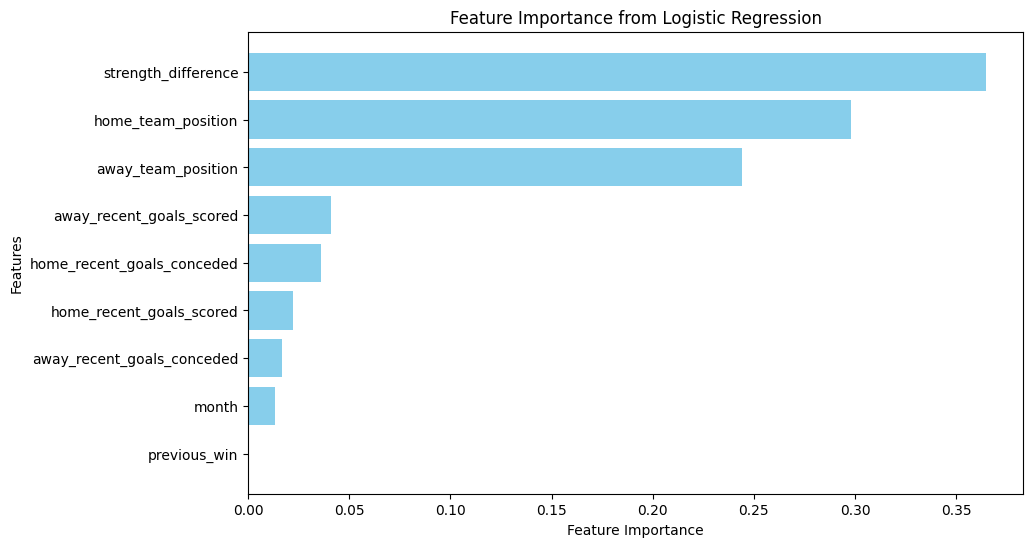


Feature Importance for n=5:


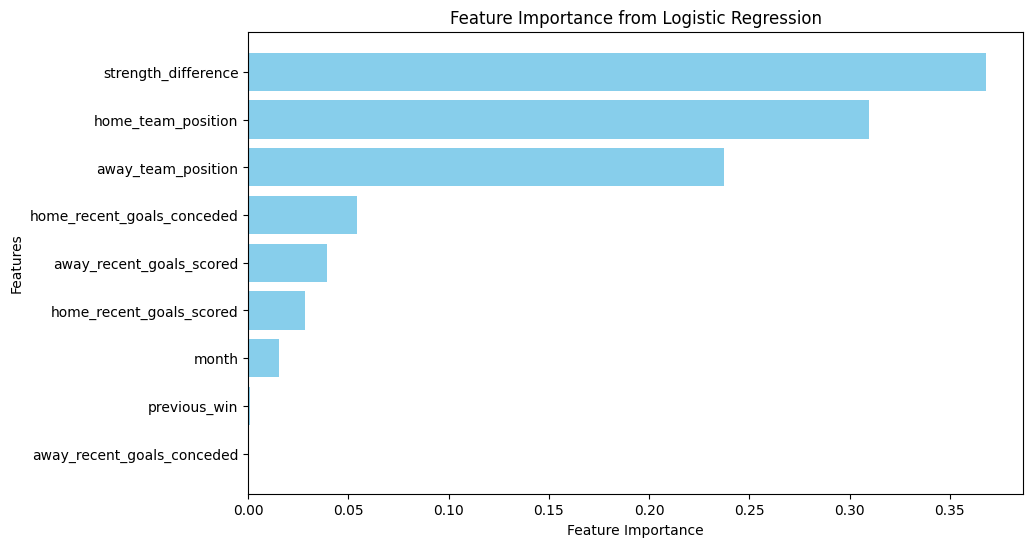


Feature Importance for n=10:


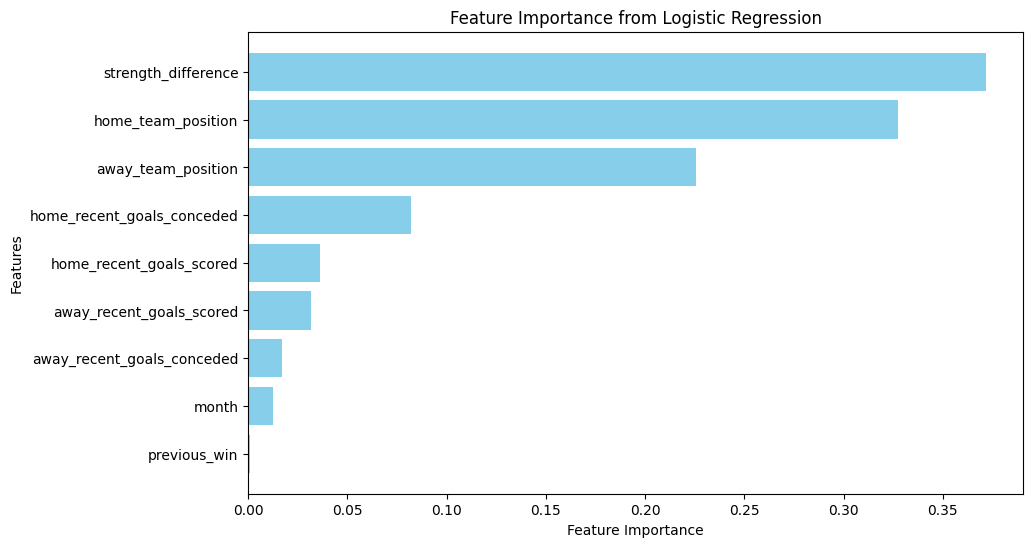

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_importance(model, features):
  
    coefficients = model.coef_[0]  
    feature_importance = np.abs(coefficients)  
    feature_importance, features = zip(*sorted(zip(feature_importance, features), reverse=True)) 

    
    plt.figure(figsize=(10, 6))
    plt.barh(features, feature_importance, color='skyblue')
    plt.xlabel('Feature Importance')
    plt.ylabel('Features')
    plt.title('Feature Importance from Logistic Regression')
    plt.gca().invert_yaxis() 
    plt.show()

print("\nFeature Importance for n=3:")
plot_feature_importance(log_reg_model_n3, [
    'home_recent_goals_scored', 'home_recent_goals_conceded',
    'away_recent_goals_scored', 'away_recent_goals_conceded',
    'previous_win', 'home_team_position', 
    'away_team_position', 'strength_difference', 'month'
])

print("\nFeature Importance for n=5:")
plot_feature_importance(log_reg_model_n5, [
    'home_recent_goals_scored', 'home_recent_goals_conceded',
    'away_recent_goals_scored', 'away_recent_goals_conceded',
    'previous_win', 'home_team_position', 
    'away_team_position', 'strength_difference', 'month'
])

print("\nFeature Importance for n=10:")
plot_feature_importance(log_reg_model_n10, [
    'home_recent_goals_scored', 'home_recent_goals_conceded',
    'away_recent_goals_scored', 'away_recent_goals_conceded',
    'previous_win', 'home_team_position', 
    'away_team_position', 'strength_difference', 'month'
])

In [8]:
#KNN 

from sklearn.neighbors import KNeighborsClassifier

def run_knn(df, n):
   
    df = calculate_recency_features(df, n)

    features = [
        'home_recent_goals_scored', 'home_recent_goals_conceded',
        'away_recent_goals_scored', 'away_recent_goals_conceded', 
        'previous_win', 'home_team_position', 
        'away_team_position', 'strength_difference', 'month'
    ]

    X = df[features]
    y = df['winner']

    X = X.dropna()
    y = y.loc[X.index] 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # K-NN model
    knn = KNeighborsClassifier()

    param_grid = {'n_neighbors': [3, 5, 7, 10]}

    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train_scaled, y_train)

    best_k = grid_search.best_params_['n_neighbors']
    print(f"Best k for n={n}: {best_k}")

    best_knn_model = grid_search.best_estimator_

    y_pred = best_knn_model.predict(X_test_scaled)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for n={n}: {accuracy:.2f}")

    print(f"Classification Report for n={n}:\n", classification_report(y_test, y_pred))

    cv_scores = cross_val_score(best_knn_model, X_train_scaled, y_train, cv=5)
    print(f"Cross-validated accuracy for n={n}: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

    return best_knn_model


In [9]:
# Run the k-NN model for different n values
print("\nResults for k-NN, n=3:")
knn_model_n3 = run_knn(df_bundesliga_recencyfeatures.copy(), 3)

print("\nResults for k-NN, n=5:")
knn_model_n5 = run_knn(df_bundesliga_recencyfeatures.copy(), 5)

print("\nResults for k-NN, n=10:")
knn_model_n10 = run_knn(df_bundesliga_recencyfeatures.copy(), 10)



Results for k-NN, n=3:


NameError: name 'GridSearchCV' is not defined

In [ ]:
#Gradient Boosting 

from sklearn.ensemble import GradientBoostingClassifier

def run_gradient_boosting(df, n):
   
    df = calculate_recency_features(df, n)

 
    features = [
        'home_recent_goals_scored', 
        'home_recent_goals_conceded', 
        'away_recent_goals_scored', 
        'away_recent_goals_conceded', 
        'previous_win', 
        'home_team_position', 
        'away_team_position', 
        'strength_difference',  
        'month' 
    ]

    X = df[features]
    y = df['winner'] 

    X = X.dropna()
    y = y.loc[X.index] 

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # GBDT model 
    gbdt = GradientBoostingClassifier(random_state=42)

    param_grid = {
        'n_estimators': [100],
        'learning_rate': [0.1],
        'max_depth': [3],
        'subsample': [0.8],
        'min_samples_split': [2],
        'min_samples_leaf': [1]
    }

    grid_search = GridSearchCV(gbdt, param_grid, cv=5, scoring='accuracy')

    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    print(f"Best Parameters for n={n}: {best_params}")

    best_gbdt_model = grid_search.best_estimator_

    y_pred = best_gbdt_model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy for n={n}: {accuracy:.2f}")

    print(f"Classification Report for n={n}:\n", classification_report(y_test, y_pred))

    cv_scores = cross_val_score(best_gbdt_model, X_train, y_train, cv=5)
    print(f"Cross-validated accuracy for n={n}: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

    return best_gbdt_model

In [ ]:
print("\nResults for Gradient Boosting, n=3:")
gbdt_model_n3 = run_gradient_boosting(df_bundesliga_recencyfeatures.copy(), 3)

print("\nResults for Gradient Boosting, n=5:")
gbdt_model_n5 = run_gradient_boosting(df_bundesliga_recencyfeatures.copy(), 5)

print("\nResults for Gradient Boosting, n=10:")
gbdt_model_n10 = run_gradient_boosting(df_bundesliga_recencyfeatures.copy(), 10)


Results for Gradient Boosting, n=3:
Best Parameters for n=3: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
Accuracy for n=3: 0.59
Classification Report for n=3:
               precision    recall  f1-score   support

           0       0.63      0.86      0.73      1883
           1       0.42      0.08      0.14       950
           2       0.51      0.55      0.53       889

    accuracy                           0.59      3722
   macro avg       0.52      0.50      0.46      3722
weighted avg       0.55      0.59      0.53      3722

Cross-validated accuracy for n=3: 0.58 ± 0.01

Results for Gradient Boosting, n=5:
Best Parameters for n=5: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}
Accuracy for n=5: 0.59
Classification Report for n=5:
               precision    recall  f1-score   support

           0       0.63      0.86 